In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from utils_data_structures import col_prefixes

In [2]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)
# grouped_df = pd.get_dummies(grouped_df, columns=['Current_Club'])

print(grouped_df['So_5_Scores_9'].isna().sum())
grouped_df['Position'].unique()

0


array(['Forward', 'Defender', 'Midfielder', 'Goalkeeper', 'Coach'],
      dtype=object)

In [3]:
epl_midfielders_df = grouped_df[grouped_df['Position'] == 'Midfielder']
epl_midfielders_df = epl_midfielders_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])

In [4]:
epl_midfielders_df.dtypes.value_counts()

float64    309
int64        4
Name: count, dtype: int64

In [5]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = epl_midfielders_df.drop(columns=columns_to_drop)
y = epl_midfielders_df[target_column]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 17.16201421526611


In [8]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,        # For reproducibility
)
# 

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9197
[LightGBM] [Info] Number of data points in the train set: 4005, number of used features: 192
[LightGBM] [Info] Start training from score 18.861928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
RMSE: 16.413085639199984


In [9]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

RMSE: 16.558437906370084


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.869e+05, tolerance: 2.482e+02
  model = cd_fast.enet_coordinate_descent(


In [10]:
with open('sorare_models/midfielders_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/midfielders_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [11]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
12518,0.0,4.622050,7.661548,11.889125
6743,0.0,4.362611,5.574336,11.679229
14003,0.0,0.182221,1.774496,4.420532
11538,0.0,0.173354,0.865476,0.532449
9647,49.5,41.107269,38.984004,43.091980
...,...,...,...,...
9439,0.0,1.003285,1.148660,1.061416
10511,0.0,0.000000,0.865476,1.059703
15109,0.0,0.000000,1.167876,1.441627
10567,44.5,44.262726,41.305839,35.973388


In [12]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
12518,0.0,4.622050,7.661548,11.889125,8.057574
6743,0.0,4.362611,5.574336,11.679229,7.205392
14003,0.0,0.182221,1.774496,4.420532,2.125750
11538,0.0,0.173354,0.865476,0.532449,0.523760
9647,49.5,41.107269,38.984004,43.091980,41.061085
...,...,...,...,...,...
9439,0.0,1.003285,1.148660,1.061416,1.071121
10511,0.0,0.000000,0.865476,1.059703,0.641726
15109,0.0,0.000000,1.167876,1.441627,0.869835
10567,44.5,44.262726,41.305839,35.973388,40.513984


In [13]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

16.444605404040143

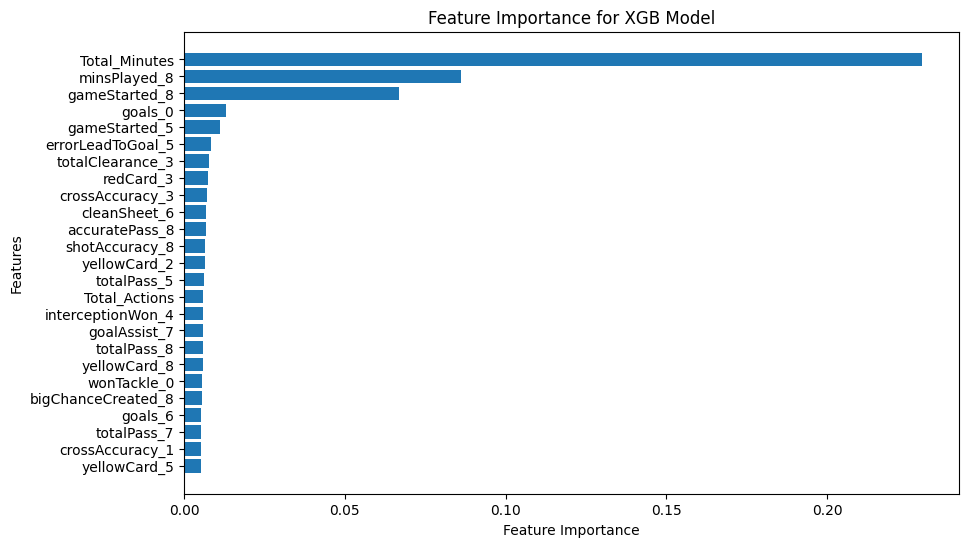

In [14]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [15]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_midfielders_df = epl_teams[epl_teams['Position'] == 'Midfielder']

epl_midfielders_df = epl_midfielders_df.reset_index(drop=True)

In [16]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_midfielders = epl_midfielders_df.drop(columns=columns_to_drop)
y_test_midfielders = epl_midfielders_df[target_column]

In [17]:
with open('sorare_models/midfielders_xgb_model.pkl', 'rb') as file:
    midfielders_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'rb') as file:
    midfielders_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/midfielders_elastic_model.pkl', 'rb') as file:
    midfielders_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [18]:
xgb_predictions = midfielders_xgb_model_loaded.predict(X_test_midfielders)
lgbm_predictions = midfielders_lgbm_model_loaded.predict(X_test_midfielders)
elastic_predictions = midfielders_elastic_model_loaded.predict(X_test_midfielders)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_midfielders_df = pd.DataFrame(y_test_midfielders)

epl_midfielders_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_midfielders_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_midfielders_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_midfielders_df['sorare_predictions'] = epl_midfielders_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_midfielders_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,12.2,15.914597,36.671409,52.724706
1,35.9,35.552879,30.542416,22.074437
2,0.0,5.107623,5.538040,9.235120


In [19]:
y_true = epl_midfielders_df['So_5_Scores_9'].to_numpy()
y_pred = epl_midfielders_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

12.767405555806869

In [20]:
saved_midfielders_df = epl_midfielders_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
saved_midfielders_df.to_csv('sorare_data/predictions/sorare_midfielders_predictions.csv', index=False)